In [1]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
from mayavi import mlab
# mlab.init_notebook()
import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom

import sys


%matplotlib notebook

# Simulate Gecko camera at spectral range 620-670 nm

In [2]:
scene_spectrum=[620,670]

GECKO = {'PIXEL_SIZE':5.5,'FULLWELL':13.5e3,'CHeight': 2048, 'CWidth': 2048 ,
              'SENSOR_ID':0, 'READOUT_NOISE':13, 'DARK_CURRENT_NOISE':125/25, 'BitDepth':10}



Now the lens attribute in the imager instance is considered as defined.


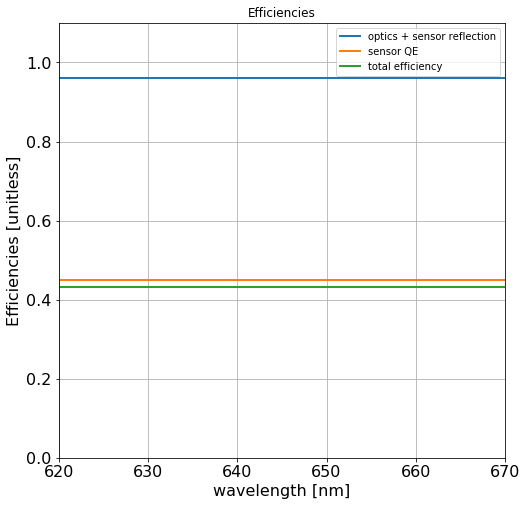

In [5]:
# Define sensor:
sensor = shdom.SensorFPA(PIXEL_SIZE = GECKO['PIXEL_SIZE'],FULLWELL = GECKO['FULLWELL'], CHeight = GECKO['CHeight'], CWidth = GECKO['CWidth'],
    SENSOR_ID = GECKO['SENSOR_ID'],  READOUT_NOISE = GECKO['READOUT_NOISE'], 
    DARK_CURRENT_NOISE = GECKO['DARK_CURRENT_NOISE'], BitDepth = GECKO['BitDepth'])


#  The Standard Gecko is a 70mm F4 refractive lens, with typical transmission in the range of 97% (excluding the losses due to spectral filters and the Sensor cover glass)
# Define lens:    
lens = shdom.LensSimple(FOCAL_LENGTH = 70.0 , DIAMETER = 17.5 , LENS_ID = '1') 

# create imager:

imager = shdom.Imager(sensor=sensor,lens=lens,scene_spectrum=scene_spectrum)
imager.assume_sensor_QE(45)
imager.assume_lens_UNITY_TRANSMISSION()
imager.update()
imager.show_efficiencies()

----> Speed in 500[km] orbit is 7.914[km/sec]
At nadir:
 Pixel footprint is 0.039[km]
 Camera footprint is 80.457
[km]
 Max esposure time 4964.144[micro sec]



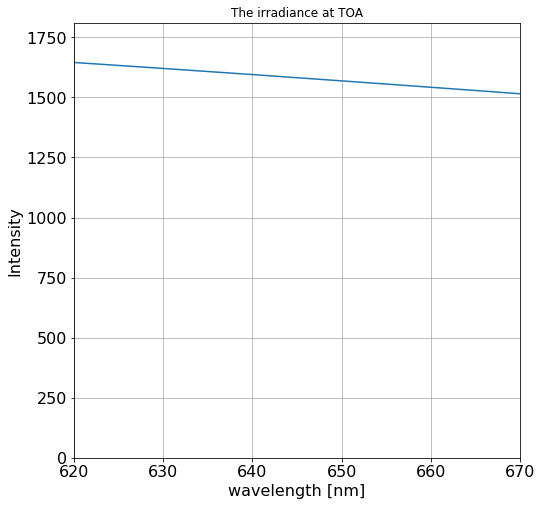

In [6]:
# set geometry:
H = 500 # km
imager.set_Imager_altitude(H=H)
# calclate footprints:
pixel_footprint, camera_footprint = imager.get_footprints_at_nadir()
max_esposure_time = imager.max_esposure_time
pixel_footprint = shdom.float_round(pixel_footprint)
camera_footprint = shdom.float_round(camera_footprint)
max_esposure_time = shdom.float_round(max_esposure_time)
print("At nadir:\n Pixel footprint is {}[km]\n Camera footprint is {}[km]\n Max esposure time {}[micro sec]\n"
      .format(pixel_footprint, camera_footprint, max_esposure_time))    

imager.calculate_scene_radiance(TYPE='SHDOM')
imager.show_scene_irradiance()
# imager.ExportConfig(file_name = 'Gecko_config.json')



# Simulate Hyperion camera at spectral range 620-670 nm

The IM200 is a modified version of the Hyperion ST200 Star Tracker, which has flown on over 13 missions since 2015.
The IM200 itself has not flown yet.
Footprints:Considering that the company offers optics with 16 mm F1.2 or 50 mm F2.0 lens, the resolution is 2048x1944
pixels and pixel pitch is 2 um (2 um provided by the company, we must insure that number). 
   
    
4 Megapixel RGB matrix  2048x1944
I assume QE >55%

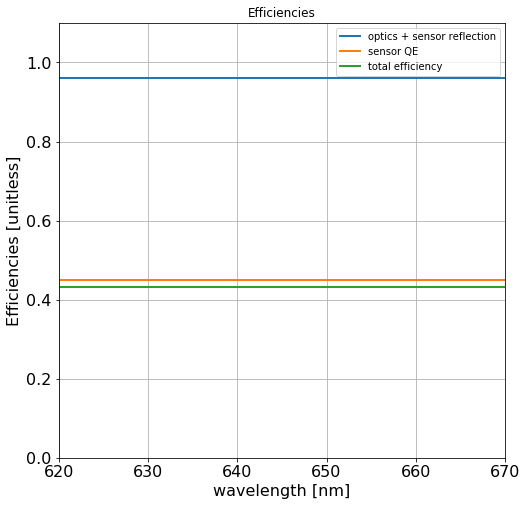

In [5]:
IM200 = {'PIXEL_SIZE':2,'FULLWELL':None,'CHeight': 2048, 'CWidth': 1944 ,
              'SENSOR_ID':4, 'READOUT_NOISE':5, 'DARK_CURRENT_NOISE':35, 'BitDepth':8}
    
    
    
    
# Define sensor:
sensor = shdom.SensorFPA(PIXEL_SIZE = IM200['PIXEL_SIZE'],FULLWELL = IM200['FULLWELL'], CHeight = IM200['CHeight'], CWidth = IM200['CWidth'],
    SENSOR_ID = IM200['SENSOR_ID'],  READOUT_NOISE = IM200['READOUT_NOISE'], 
    DARK_CURRENT_NOISE = IM200['DARK_CURRENT_NOISE'], BitDepth = IM200['BitDepth'])

# Define lens:    
lens = shdom.LensSimple(FOCAL_LENGTH = 50.0 , DIAMETER = 25.0 , LENS_ID = '4') 

# create imager:
scene_spectrum=[620,670]

imager = shdom.Imager(sensor=sensor,lens=lens,scene_spectrum=scene_spectrum,temp=20)
imager.assume_sensor_QE(45)
imager.assume_lens_UNITY_TRANSMISSION()
imager.update()
imager.show_efficiencies()
    

----> Speed in 500[km] orbit is 7.914[km/sec]
At nadir:
 Pixel footprint is 0.02[km]
 Camera footprint is 38.88
[km]
 Max esposure time 2527.2[micro sec]



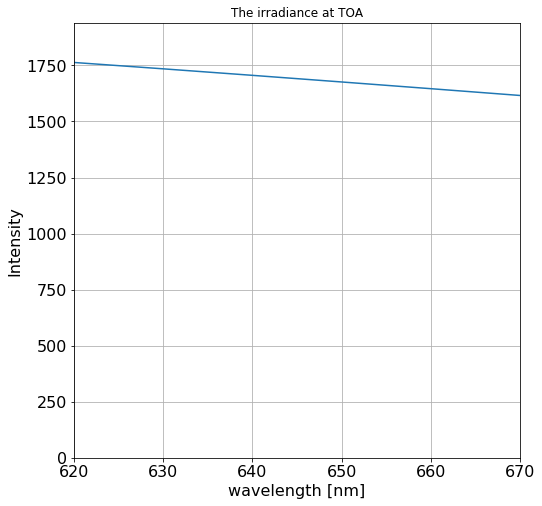

In [6]:
# set geometry:
H = 500 # km
imager.set_Imager_altitude(H=H)
pixel_footprint, camera_footprint = imager.get_footprints_at_nadir()
max_esposure_time = imager.max_esposure_time
pixel_footprint = shdom.float_round(pixel_footprint)
camera_footprint = shdom.float_round(camera_footprint)
max_esposure_time = shdom.float_round(max_esposure_time)
print("At nadir:\n Pixel footprint is {}[km]\n Camera footprint is {}\n[km]\n Max esposure time {}[micro sec]\n"
      .format(pixel_footprint, camera_footprint, max_esposure_time))    

imager.calculate_scene_radiance(TYPE='SHDOM')
imager.show_scene_irradiance()

# Simulate Raptor's Owl 1280 VIS-SWIR Digital camera at spectral range 1628-1652 nm (as in MODIS)

opposed to VIS cameras, in the SWIR case we don't have any information about the lens, so we will assume it here.
We will require certain footprint on the graond at nadir view and than calculate the focal length. Than we will requaire minimal radiance that reach the lens, then calculate the diameter of the lens that will create gathering of ligth such that a pixel reaches its full well with the maximum expusure time. 

Remember to set sensor QE and lens TRANSMISSION!
Now the lens attribute in the imager instance is considered as defined.


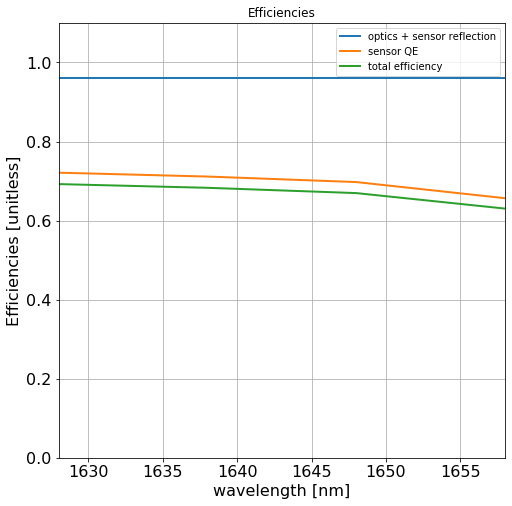

In [8]:
SWIR = {'PIXEL_SIZE':10,'FULLWELL':500e3,'CHeight': 1280 , 'CWidth': 1024 ,
        'SENSOR_ID':3, 'READOUT_NOISE':160, 'DARK_CURRENT_NOISE':19e3,
        'BitDepth':14,'TYPE':'SWIR'}
    
 
# Define sensor:
sensor = shdom.SensorPFA(PIXEL_SIZE = SWIR['PIXEL_SIZE'],FULLWELL = SWIR['FULLWELL'], 
                         CHeight = SWIR['CHeight'], CWidth = SWIR['CWidth'],
                         SENSOR_ID = SWIR['SENSOR_ID'],  READOUT_NOISE = SWIR['READOUT_NOISE'], 
                         DARK_CURRENT_NOISE = SWIR['DARK_CURRENT_NOISE'], BitDepth = SWIR['BitDepth']
                         ,TYPE=SWIR['TYPE'])


SENSOR_QE_CSV_FILE = 'allide_swir.csv'
sensor.Load_QE_table(SENSOR_QE_CSV_FILE)

# ---------------------------------------------------------------------------------

# create imager:
scene_spectrum=[1628, 1658]

imager = shdom.Imager(sensor=sensor,scene_spectrum=scene_spectrum)
imager.assume_lens_UNITY_TRANSMISSION()
imager.update()
imager.show_efficiencies()    

----> Speed in 500[km] orbit is 7.914[km/sec]
The focal length will change in this step, This what do you want to do?
----> Focal length is set to 71.429[mm]
----> Exposure bound is set to 8845.201[micro sec]
----> Dynamic range bound is set to 141.998 or 43.046[db]
----> Noise floor bound is set to 3521.177[electrons]
----> SNR is 687.326 or 56.99[db]

Update minimum lens diameter
The diameter of the lens will change in this step, Is that what do you want to do?
----> Diameter is changed to 48.261[mm]

Report all
----> Diameter is 48.261[mm]
----> SNR is 687.326 or 56.743[db]
----> Full_well is 500000.0[electrons]


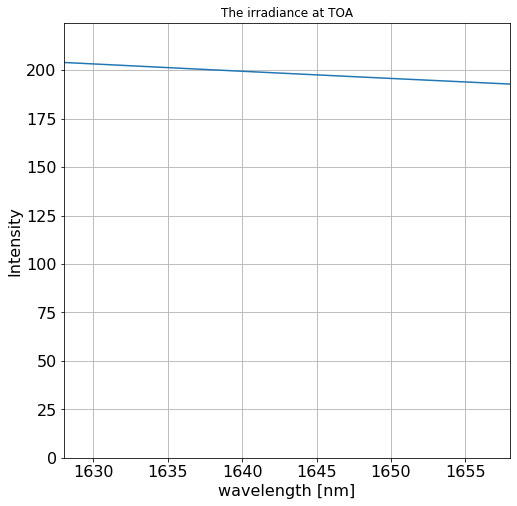

In [9]:
# set geometry:
H = 500 # km
imager.set_Imager_altitude(H=H)

# set required pixel footprint:
Required_pixel_footprint = 0.07 # km
# what should be the focal length of the lens? set the required pixel footprint, then see the printed Focal lennth it requaires.
imager.set_pixel_footprint(Required_pixel_footprint)

# set required radiance that should reach the lens, what should be the diameter of the lens
# such that the pixel will reache its full well:
imager.calculate_scene_radiance(rho=0.15)
imager.update_minimum_lens_diameter()

imager.calculate_scene_radiance(TYPE='SHDOM')
imager.show_scene_irradiance()
imager.ExportConfig(file_name = 'Hypothetic_SWIR_camera_config.json')
